In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot
import seaborn

In [2]:
FIG_SIZE = (6, 3)
FIG_SIZE_WIDE = (9, 3)

PALETTE = seaborn.color_palette()
DATE_RANGE = pd.to_datetime('2019-11-01'), pd.to_datetime('2022-08-31')

matplotlib.rcParams['figure.figsize'] = FIG_SIZE
# matplotlib.rcParams['legend.framealpha'] = 1
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

SEED = 12345
SAVEFIG = False

def _savefig(fig, name):
    import os
    fig.savefig(
        os.path.join('..', 'figures', '{}.pdf'.format(name)),
        bbox_inches='tight'
    )
    
savefig = _savefig if SAVEFIG else lambda x, y: None

In [36]:
RE_SEMVER = r'^(?:(?:v|V)\.?)?(?P<major>\d{1,7})(?:\.(?P<minor>\d+)(?:\.(?P<patch>\d+))?)?(?P<misc>.*)$'
RE_DATE = r'^\d{8}(?:[0-9:]+)$' 
RE_SHA = r'^[a-zA-Z0-9]{7,8}[a-zA-Z0-9]{32,33}$'

## Load data

In [133]:
df_releases = (
    pd.read_csv('../data/releases.csv.gz', parse_dates=['date'])
    # Detect versioning scheme
    .assign(components=lambda d: d.release.str.match(RE_SEMVER))
    .assign(datebased=lambda d: d.release.str.match(RE_DATE))
    .assign(sha=lambda d: d.release.str.match(RE_SHA))
    .assign(other=True)
    .assign(versioning=lambda d: d[['datebased', 'sha', 'components', 'other']].idxmax(axis=1))
    # Detect number of components for semver
    .assign(versioning=lambda d: np.where(d.versioning == 'components', (d.release.str.count('\.') + 1).fillna(0).astype(int).astype(str) + ' components', d.versioning))
    .replace({'versioning': {'1 components': '1 component', 'datebased': 'date', '4 components': '4+ components', '5 components': '4+ components'}})
    .drop(columns=['components', 'datebased', 'sha', 'other'])
)

In [114]:
df_snapshots = (
    pd.read_csv('../data/workflow_files.csv.gz', parse_dates=['date'])
    [['repository', 'date', 'filename', 'workflow']]
)

In [153]:
df_steps = (
    pd.read_csv('../data/steps.csv.gz')
    [['workflow', 'uses']]
    [lambda d: ~d.uses.isnull()]
    [lambda d: ~d.uses.str.startswith(('docker://', './', 'http'))]
    [lambda d: d.uses.str.count('/') == 1]
    .assign(anchor=lambda d: d.uses.str.split('@', n=1).str[1])
    # Detect versioning scheme
    .assign(components=lambda d: d.anchor.str.match(RE_SEMVER))
    .assign(date=lambda d: d.anchor.str.match(RE_DATE))
    .assign(sha=lambda d: d.anchor.str.match(RE_SHA))
    .assign(other=True)
    .fillna({'components': False, 'date': False, 'sha': False})
    .assign(versioning=lambda d: d[['date', 'sha', 'components', 'other']].idxmax(axis=1))
    # Detect number of components for semver
    .assign(versioning=lambda d: np.where(d.versioning == 'components', (d.anchor.str.count('\.').fillna(0) + 1).astype(int).astype(str) + ' components', d.versioning))
    .replace({'versioning': {'1 components': '1 component', '4 components': '4+ components', '5 components': '4+ components'}})
)

## Versioning practices for Actions

### Monthly proportion of releases for each versioning practice

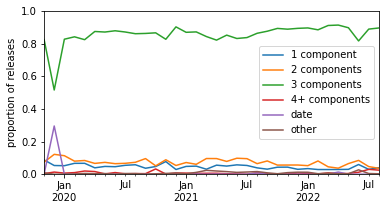

In [145]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    df_releases
    .groupby([pd.Grouper(key='date', freq='M'), 'versioning'])
    .agg(releases=('release', 'count'))
    .unstack()['releases']
    .fillna(0).astype(int)
    .groupby(pd.Grouper(level=0, freq='M'))
    .first()
    .apply(lambda s: s / s.sum(), axis=1)
)

temp.plot(ax=ax, color=PALETTE, )
ax.legend(title=None)

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel='proportion of releases',
    ylim=(0, 1),
)

savefig(fig, 'version_monthly_releases')

In [146]:
display(temp.describe().T)
display(temp.iloc[-1])

,count,mean,std,min,25%,50%,75%,max
versioning,,,,,,,,
1 component,88.0,0.020815,0.026080,0.0,0.000000,0.000000,0.043070,0.087479
2 components,88.0,0.097791,0.192244,0.0,0.000000,0.054658,0.086090,1.000000
3 components,88.0,0.868385,0.195160,0.0,0.841268,0.894552,1.000000,1.000000
4+ components,88.0,0.004551,0.007829,0.0,0.000000,0.000000,0.006678,0.033333
date,88.0,0.003847,0.031541,0.0,0.000000,0.000000,0.000000,0.295652
other,88.0,0.004611,0.007973,0.0,0.000000,0.000000,0.005157,0.038168


versioning
1 component      0.024523
2 components     0.024523
3 components     0.929155
4+ components    0.010899
date             0.000000
other            0.010899
Name: 2022-09-30 00:00:00+00:00, dtype: float64

### Monthly proportion of Actions for each versioning practice

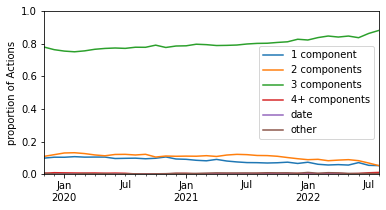

In [221]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    df_releases
    .assign(action=lambda d: d.owner + '/' + d.repo)
    .sort_values(['date', 'action'])
    .drop_duplicates(['date', 'action'], keep='last')
    # Fill the "gaps"
    .set_index('date')
    .groupby('action', as_index=False)
    .resample('M')
    .ffill()
    .reset_index()
    .groupby([pd.Grouper(key='date', freq='M'), 'versioning'])
    .agg(actions=('action', 'count'))  # No duplicate so "count" == "nunique"
    .unstack()['actions']
    .fillna(0)
    .apply(lambda s: s / s.sum(), axis=1)
)

temp.plot(ax=ax)
ax.legend(title=None)

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel='proportion of Actions',
    ylim=(0, 1)
)

savefig(fig, 'version_monthly_actions')

In [222]:
display(temp.describe().T)
display(temp.iloc[-1])

,count,mean,std,min,25%,50%,75%,max
versioning,,,,,,,,
1 component,105.0,0.029576,0.040968,0.000000,0.000000,0.000000,0.070671,0.107595
2 components,105.0,0.108990,0.108445,0.000000,0.000000,0.095101,0.126437,0.333333
3 components,105.0,0.854034,0.115796,0.666667,0.756322,0.827519,1.000000,1.000000
4+ components,105.0,0.003350,0.007607,0.000000,0.000000,0.000000,0.004456,0.055556
date,105.0,0.000524,0.001518,0.000000,0.000000,0.000000,0.000829,0.009709
other,105.0,0.003526,0.006106,0.000000,0.000000,0.000000,0.005263,0.028571


versioning
1 component      0.030928
2 components     0.041237
3 components     0.896907
4+ components    0.010309
date             0.000000
other            0.020619
Name: 2022-09-30 00:00:00+00:00, dtype: float64

## Versioning practices in workflows

### Monthly proportion of steps for each versioning practice

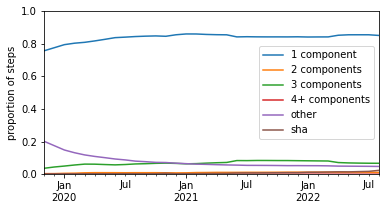

In [155]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    df_steps[['workflow', 'versioning']]
    .merge(
        df_snapshots,
        how='inner',
        on='workflow',
    )
    .groupby([pd.Grouper(key='date', freq='M'), 'versioning'])
    .agg(steps=('workflow', 'count'))  # We do not count workflows but steps
    .unstack()['steps']
    .fillna(0).astype(int)
    .groupby(pd.Grouper(level=0, freq='M'))
    .first()
    .apply(lambda s: s / s.sum(), axis=1)
)

temp.plot(ax=ax, color=PALETTE, )
ax.legend(title=None)

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel='proportion of steps',
    ylim=(0, 1),
)

savefig(fig, 'version_monthly_steps')

In [156]:
display(temp.describe().T)
display(temp.iloc[-1])

,count,mean,std,min,25%,50%,75%,max
versioning,,,,,,,,
1 component,35.0,0.837842,0.023652,0.756733,0.840877,0.842539,0.853407,0.859969
2 components,35.0,0.010047,0.002423,0.003503,0.009059,0.010901,0.012018,0.012615
3 components,35.0,0.068356,0.011825,0.036348,0.062345,0.067251,0.081240,0.084219
4+ components,35.0,0.000128,0.000142,0.000000,0.000023,0.000057,0.000233,0.000516
other,35.0,0.075968,0.038018,0.047146,0.052364,0.058434,0.083854,0.201883
sha,35.0,0.007660,0.006244,0.001462,0.002979,0.005215,0.010774,0.025508


versioning
1 component      0.849535
2 components     0.010901
3 components     0.066895
4+ components    0.000014
other            0.047146
sha              0.025508
Name: 2022-09-30 00:00:00, dtype: float64